## Step 3: Preparing data for training

In [2]:
import pandas as pd
import yfinance as yf
import json
from datetime import datetime
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### 3.1. Importing daily scores from news folder

In [3]:
with open('./data/news/bert_daily_scores.json', 'r') as file:
    sentimentScores = json.load(file)
#endwith

dfSentiment = pd.DataFrame(list(sentimentScores.items()), columns=['jsonDate', 'sentiment'])
dfSentiment['date'] = pd.to_datetime(dfSentiment['jsonDate'], format='%Y-%m-%d')
dfSentiment.head()

,jsonDate,sentiment,date
0,2015-01-01,"[0.08557845652103424, 0.05136130377650261, 0.0...",2015-01-01
1,2015-01-02,"[0.03513030707836151, 0.04333778843283653, 0.0...",2015-01-02
2,2015-01-03,"[0.13386961817741394, 0.08151617646217346, 0.0...",2015-01-03
3,2015-01-04,"[0.014707638882100582, 0.01659909263253212, 0....",2015-01-04
4,2015-01-05,"[0.009732341393828392, 0.010922754183411598, 0...",2015-01-05


### 3.2. Importing daily stock data from stock folder

In [4]:
start_date = datetime(2015,1,1)
end_date = datetime(2024,1,20)

In [5]:
csvFilePath = yf.download('GOOGL', start=start_date, end=end_date)
csvFilePath.reset_index(inplace=True)
dfCsv = csvFilePath[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
dfCsv['Symbol'] = 'GOOGL'
dfCsv = dfCsv[['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
dfCsv.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
C:\Users\mjvis\AppData\Local\Temp\ipykernel_14044\1924711905.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCsv['Symbol'] = 'GOOGL'


Price,Symbol,Date,Open,High,Low,Close,Volume
Ticker,,,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
0,GOOGL,2015-01-02,26.503287,26.662528,26.268410,26.351515,26480000
1,GOOGL,2015-01-05,26.232086,26.273886,25.764323,25.849415,41182000
2,GOOGL,2015-01-06,25.901167,25.936498,25.157225,25.211466,54456000
3,GOOGL,2015-01-07,25.425943,25.452813,25.062679,25.137321,46918000
4,GOOGL,2015-01-08,24.956185,25.254260,24.633228,25.224901,73054000


In [6]:
file_name = f"Google.csv"
file_path = os.path.join('./data/stocks', file_name)
    
dfCsv.to_csv(file_path)

### 3.3. Merge both the imported data with date

In [15]:
dfCsv['date'] = pd.to_datetime(dfCsv['Date'], format='%d-%b-%Y')

if dfCsv['date'].dt.tz is None:
    dfCsv['date'] = dfCsv['date'].dt.tz_localize('UTC')
else:
    dfCsv['date'] = dfCsv['date'].dt.tz_convert('UTC')

# If dfSentiment['date'] is naive, convert it to UTC as well:
if dfSentiment['date'].dt.tz is None:
    dfSentiment['date'] = dfSentiment['date'].dt.tz_localize('UTC')

dfCsv.tail()

dfCsv.reset_index(drop=True, inplace=True)
dfSentiment.reset_index(drop=True, inplace=True)

dfCsv.columns = dfCsv.columns.get_level_values(0)
dfSentiment.columns = dfSentiment.columns.get_level_values(0)

In [16]:
dfCsv['date'] = pd.to_datetime(dfCsv['date'], utc=True)
dfSentiment['date'] = pd.to_datetime(dfSentiment['date'], utc=True)


dfMerged = pd.merge(dfCsv, dfSentiment, on='date', how='left')

dfMerged = pd.merge(dfCsv, dfSentiment, on='date', how='left')


dfSentimentColumns = pd.DataFrame(dfMerged['sentiment'].apply(lambda x: x[:5] if isinstance(x, list) else [None]*5).tolist(), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])


dfMerged = pd.concat([dfMerged, dfSentimentColumns], axis=1)


dfMerged = dfMerged.drop(columns=['Symbol', 'date', 'sentiment', 'jsonDate'])
dfMerged.tail()


,Date,Open,High,Low,Close,Volume,feature1,feature2,feature3,feature4,feature5
2272,2024-01-12,141.991146,142.518623,141.145200,141.971237,18768600,0.331515,0.092537,0.093824,0.217307,0.264818
2273,2024-01-16,141.324338,143.663162,140.776952,141.812012,22670500,0.019436,0.026503,0.128215,0.403235,0.422611
2274,2024-01-17,140.677451,141.165110,138.239096,140.796875,20968600,0.032337,0.034316,0.089462,0.291251,0.552633
2275,2024-01-18,141.374114,143.523840,141.314402,142.797302,25746400,0.067894,0.039609,0.073186,0.251253,0.568058
2276,2024-01-19,144.051306,145.753161,143.693019,145.683502,33300700,0.043374,0.042171,0.092521,0.292414,0.529520


### 3.4. Saving the merged data

In [17]:
outputCsvPath = './data/stocks/GoogleWithSentiments.csv'
dfMerged.to_csv(outputCsvPath, index=False)

### 3.5. Check data by plotting the graph

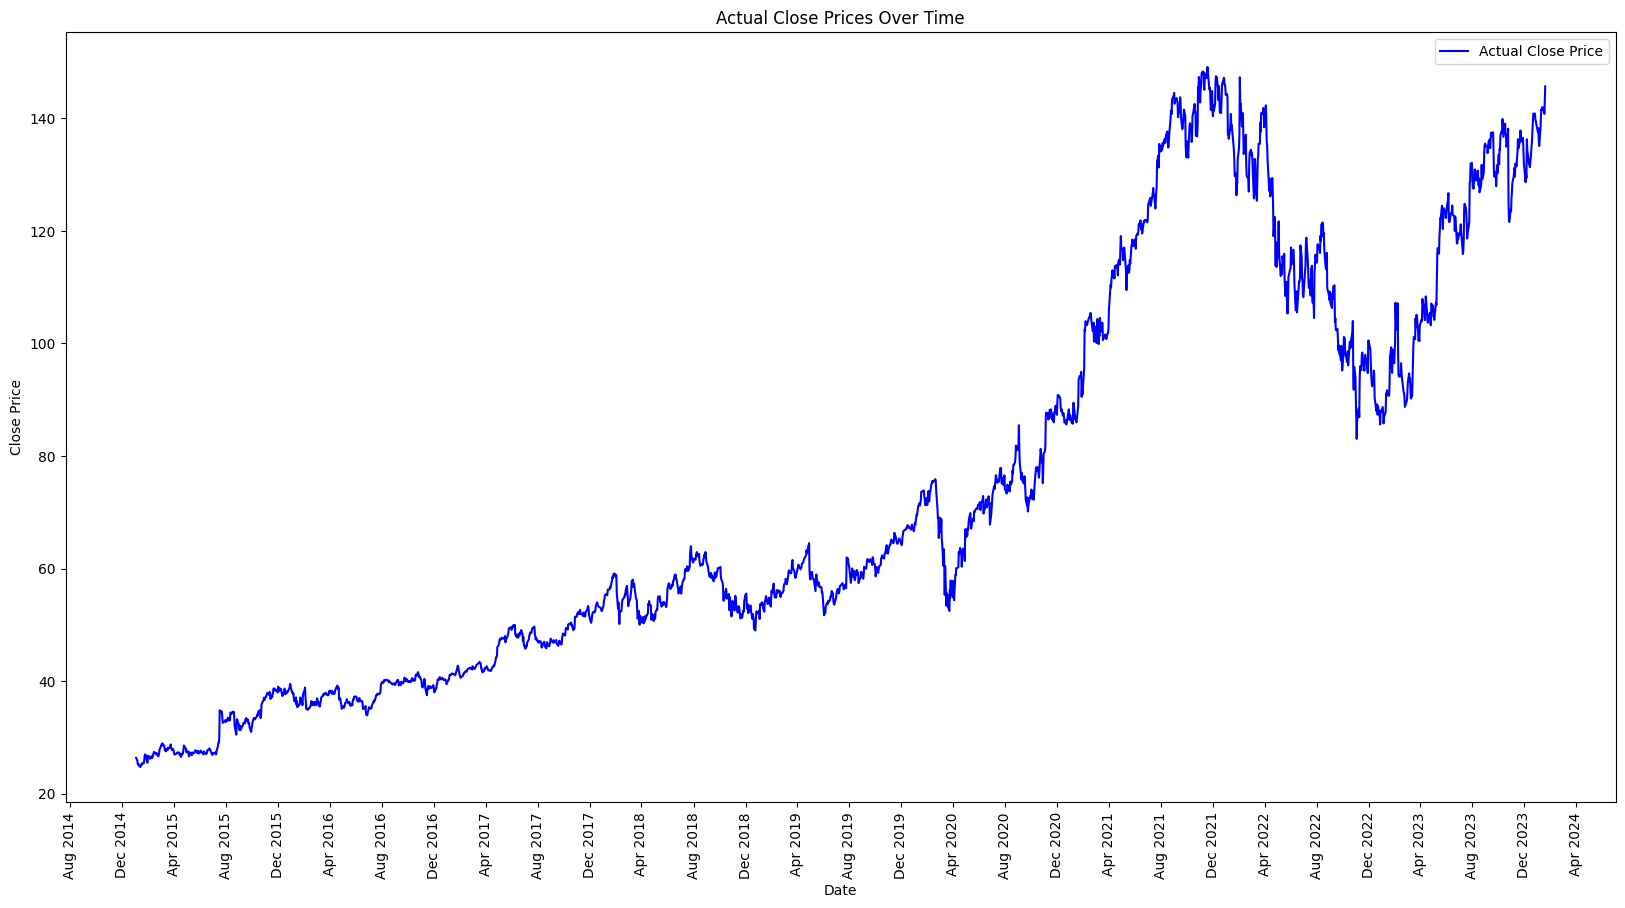

In [18]:
dates = dfMerged['Date'].values
close_prices = dfMerged['Close'].values

# Sample dates for x-axis labels
sampleInterval = 60  # Adjust to show fewer date labels
sampledDates = dates[::sampleInterval]

# Plot the actual close prices
plt.figure(figsize=(20, 10))
plt.plot(dates, close_prices, label='Actual Close Price', color='blue')

# Set labels and x-axis formatting
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(sampledDates, rotation=90)

# Set x-axis to display month and year every two months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Add title, legend, and show plot
plt.title("Actual Close Prices Over Time")
plt.legend()
plt.show()
